In [8]:
import os
from preprocessing import Preprocessing, SplitAudio
import torchaudio

import torch
from torch.utils.data import DataLoader, TensorDataset

from torch import nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
ruta_carpeta = "./MusicCaps"  # Reemplaza con la ruta real de tu carpeta

archivos = os.listdir(ruta_carpeta)

X = []
metadata = []
sample_rate_red = 16000
for archivo in archivos[:33]:
    waveform, samp_rt = torchaudio.load("./MusicCaps/" + archivo)
    f, s = SplitAudio(waveform, sample_rate = samp_rt, new_sample_rate = sample_rate_red)

    f_spec, f_maxi, f_mini = Preprocessing(f, 16000, resampler_f = False)
    s_spec, s_maxi, s_mini = Preprocessing(s, 16000, resampler_f = False)

    X += [f_spec, s_spec]
    metadata += [{"nombre":archivo, "parte":"first", "minimum":f_mini, "maximum":f_maxi},
                 {"nombre":archivo, "parte":"second", "minimum":s_mini, "maximum":s_maxi}]

c:\Users\jpeir\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [3]:
X_tensor = torch.stack(X)  # (N, 256, 256)
print(X_tensor.shape)
X_tensor = X_tensor.unsqueeze(1)  # (N, 1, 256, 256)
print(X_tensor.shape)

batch_size = 64
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

torch.Size([66, 256, 256])
torch.Size([66, 1, 256, 256])


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, stride=2, padding=1),  # Reduce tamaño a 128x128
            nn.Tanh()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.SGD(autoencoder.parameters(), lr=0.01, momentum=0.9)


In [5]:
from torchinfo import summary
summary(autoencoder, input_size=(64, 1, 256, 256))  # (batch_size, channels, height, width)

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [64, 1, 256, 256]         --
├─Sequential: 1-1                        [64, 128, 128, 128]       --
│    └─Conv2d: 2-1                       [64, 128, 128, 128]       1,280
│    └─Tanh: 2-2                         [64, 128, 128, 128]       --
├─Sequential: 1-2                        [64, 1, 256, 256]         --
│    └─ConvTranspose2d: 2-3              [64, 128, 256, 256]       147,584
│    └─Conv2d: 2-4                       [64, 1, 256, 256]         1,153
│    └─Sigmoid: 2-5                      [64, 1, 256, 256]         --
Total params: 150,017
Trainable params: 150,017
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 625.19
Input size (MB): 16.78
Forward/backward pass size (MB): 5402.26
Params size (MB): 0.60
Estimated Total Size (MB): 5419.64

In [17]:
num_epochs = 3

perdida = []
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:  
        batch = batch[0]

        optimizer.zero_grad()

        outputs = autoencoder(batch)
        loss = criterion(outputs, batch)

        perdida.append(loss.item())

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print(f"Pérdida batch: {loss.item():.6f}")
    avg_loss = total_loss / len(dataloader)
    print(f"Época [{epoch+1}/{num_epochs}], Pérdida: {avg_loss:.6f}")

print("Entrenamiento finalizado ✅")

Pérdida batch: 0.029521
Pérdida batch: 0.030962
Época [1/3], Pérdida: 0.030242
Pérdida batch: 0.028261
Pérdida batch: 0.018119
Época [2/3], Pérdida: 0.023190
Pérdida batch: 0.026751
Pérdida batch: 0.013606
Época [3/3], Pérdida: 0.020179
Entrenamiento finalizado ✅


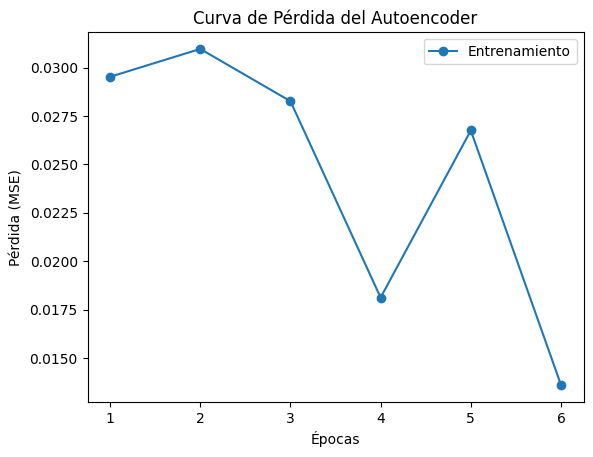

In [18]:
plt.plot(range(1, len(perdida)+1), perdida, label="Entrenamiento", marker='o')
plt.xlabel("Épocas")
plt.ylabel("Pérdida (MSE)")
plt.title("Curva de Pérdida del Autoencoder")
plt.legend()
plt.show()